In [1]:
%load_ext autoreload
%autoreload 2

import torch
import energyflow as ef
import numpy as np
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from dataset import  FalconDataset
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn.functional as F

from main import preprocess_emd
from edgenet import EdgeNet

In [2]:
dataset = FalconDataset('')

In [3]:
kwargs = {'num_workers': 1, 'pin_memory': True} 
loader = DataLoader(dataset,
        batch_size=256, shuffle=True, drop_last=True, **kwargs)

In [4]:
data_h = next(iter(loader))

In [5]:
data_h

Batch(batch=[29248], edge_index=[2, 330262], x=[29248, 3])

In [6]:
device = torch.device('cuda:1')

model = EdgeNet().to(device)
checkpoint = torch.load("mnist_cnn.pt_old", map_location='cpu')
model.load_state_dict(checkpoint)
del checkpoint
torch.cuda.empty_cache()

In [7]:
model.eval()
losses = []
with torch.no_grad():
    for batch_idx, (data_h) in enumerate(loader):
        if batch_idx < 9:
            data = data_h.to(device)
            output = model(data)

            #if (batch_idx not in target_emds):
            #    pixel_list = preprocess(data_h)
            #    target_emds[batch_idx] = torch.from_numpy(ef.emd.emds(pixel_list, R=40.0)).float().to(device)
            #target = target_emds[batch_idx]
            nodes_list = preprocess_emd(data_h)
            target = torch.from_numpy(ef.emd.emds(nodes_list, R=1.0)).float().to(device)
            output_dist = torch.cdist(output, output, p=2.1)

            loss = F.mse_loss(output_dist, target).detach().cpu()
            losses.append(loss)

In [8]:
losses

[tensor(545.3649),
 tensor(922.1333),
 tensor(6856.6699),
 tensor(3074.6614),
 tensor(4243.5122),
 tensor(10760.1875),
 tensor(2077.6597),
 tensor(5307.1074),
 tensor(10273.4189)]

In [9]:
losses = [itm.numpy() for itm in losses]



In [10]:
losses = [itm.flatten()[0] for itm in losses]

In [11]:
losses

[545.36487,
 922.1333,
 6856.67,
 3074.6614,
 4243.512,
 10760.1875,
 2077.6597,
 5307.1074,
 10273.419]

In [12]:
np.mean(losses)

4895.635

In [13]:
target_h = target.cpu().numpy()

In [14]:
output_dist_h = output_dist.cpu().numpy()

In [15]:
output_dist_h

array([[  0.       , 377.55682  , 310.34933  , ..., 361.37024  ,
        386.07986  , 364.59268  ],
       [377.55682  ,   0.       ,  67.46842  , ...,  17.114325 ,
         16.939966 ,  14.4482355],
       [310.34933  ,  67.46842  ,   0.       , ...,  51.18029  ,
         76.28963  ,  55.227383 ],
       ...,
       [361.37024  ,  17.114325 ,  51.18029  , ...,   0.       ,
         26.804914 ,  11.579597 ],
       [386.07986  ,  16.939966 ,  76.28963  , ...,  26.804914 ,
          0.       ,  28.977686 ],
       [364.59268  ,  14.4482355,  55.227383 , ...,  11.579597 ,
         28.977686 ,   0.       ]], dtype=float32)

In [16]:
target_h

array([[  0.      , 434.32565 , 504.7121  , ..., 431.77148 , 443.16403 ,
        436.50864 ],
       [434.32565 ,   0.      ,  75.37461 , ...,  15.628157,  31.538633,
         19.261648],
       [504.7121  ,  75.37461 ,   0.      , ...,  70.979485,  79.5031  ,
         73.44816 ],
       ...,
       [431.77148 ,  15.628157,  70.979485, ...,   0.      ,  31.478334,
         24.414173],
       [443.16403 ,  31.538633,  79.5031  , ...,  31.478334,   0.      ,
         26.38826 ],
       [436.50864 ,  19.261648,  73.44816 , ...,  24.414173,  26.38826 ,
          0.      ]], dtype=float32)

In [17]:
h1 = target_h.flatten()[np.nonzero(target_h.flatten())]

In [18]:
h2 = output_dist_h.flatten()[np.nonzero(output_dist_h.flatten())]

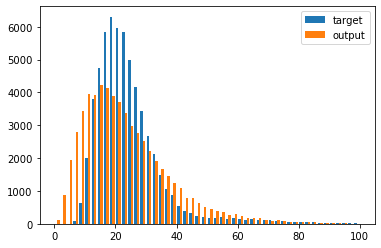

In [19]:
plt.hist([h1,h2],bins=50,range=[0,100],label=['target','output'])
plt.legend()

(array([  66.,   52.,   74.,  102.,  160.,  134.,  170.,  194.,  210.,
         258.,  276.,  322.,  414.,  510.,  646.,  758.,  992., 1224.,
        1458., 1832., 2286., 2622., 3126., 3650., 4028., 4480., 5086.,
        5118., 4946., 4292., 3272., 2666., 1958., 1298.,  804.,  616.,
         412.,  284.,  236.,  200.,  114.,   74.,   82.,   78.,   72.,
          74.,   72.,   72.,   56.,   60.]),
 array([-50., -48., -46., -44., -42., -40., -38., -36., -34., -32., -30.,
        -28., -26., -24., -22., -20., -18., -16., -14., -12., -10.,  -8.,
         -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,
         16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,
         38.,  40.,  42.,  44.,  46.,  48.,  50.], dtype=float32),
 <a list of 50 Patch objects>)

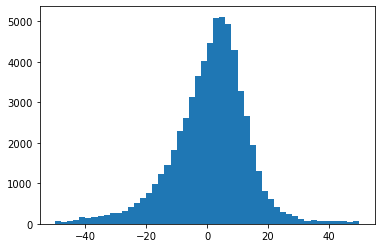

In [20]:
plt.hist(h1 - h2, bins=50,range=[-50,50])